In [1]:
import time
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

In [2]:
AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]]
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)

In [3]:
# The predictions were obtained by running a separate Python script in an EC2 instance with GPU.
timellm_preds = [
    431.72, 413.41, 452.68, 462.88, 485.95, 504.97, 532.37, 495.13, 500.83, 476.60, 479.17, 498.57,
    731.65, 713.59, 753.33, 762.89, 786.24, 805.15, 832.91, 795.53, 801.30, 776.58, 779.35, 798.53
]

In [4]:
Y_test_df['TimeLLM'] = timellm_preds
Y_test_df.head()

,unique_id,ds,y,trend,y_[lag12],month,TimeLLM
0,Airline1,1960-01-31,417.0,132,360.0,-0.500000,431.72
1,Airline1,1960-02-29,391.0,133,342.0,-0.409091,413.41
2,Airline1,1960-03-31,419.0,134,406.0,-0.318182,452.68
3,Airline1,1960-04-30,461.0,135,396.0,-0.227273,462.88
4,Airline1,1960-05-31,472.0,136,420.0,-0.136364,485.95


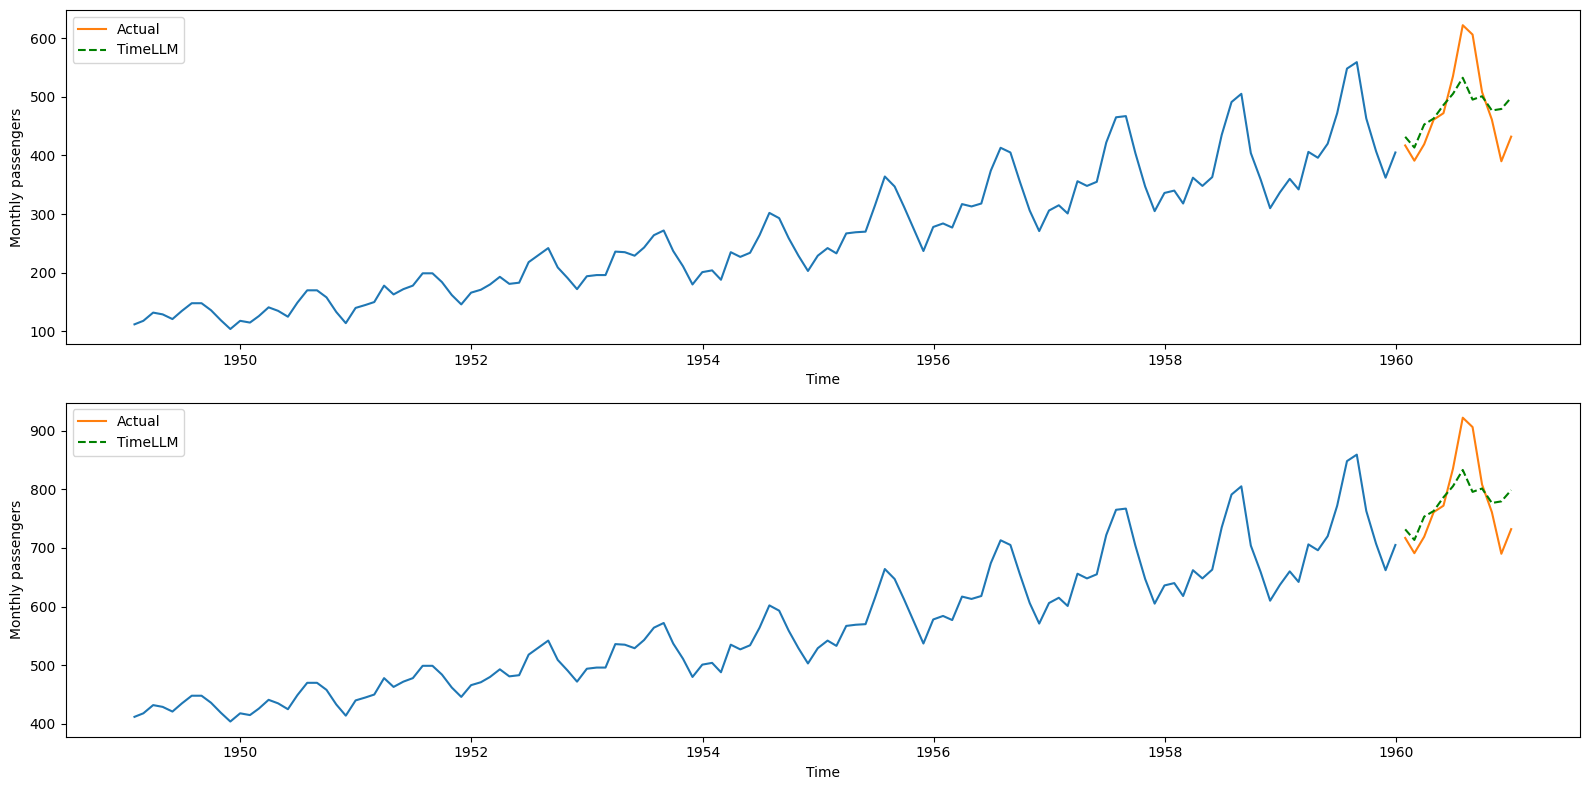

In [5]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
ax1.plot(airline1_df['ds'], airline1_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
ax2.plot(airline2_df['ds'], airline2_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()

In [7]:
nbeats = NBEATS(h=12, input_size=36, max_steps=100)
mlp = MLP(h=12, input_size=36, max_steps=100)

nf = NeuralForecast(models=[nbeats, mlp], freq='M')

nf.fit(df=Y_train_df, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Global seed set to 1
Global seed set to 1


Epoch 99: 100%|████████████████| 1/1 [00:00<00:00, 10.64it/s, v_num=108, train_loss_step=11.40, train_loss_epoch=11.60]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 99: 100%|█| 1/1 [00:00<00:00,  8.26it/s, v_num=108, train_loss_step=11.40, train_loss_epoch=11.60, valid_loss=15.
Epoch 99: 100%|█| 1/1 [00:00<00:00,  7.81it/s, v_num=108, train_loss_step=11.40, train_loss_epoch=11.40, valid_loss=15.
Epoch 99: 100%|████████████████| 1/1 [00:00<00:00, 22.73it/s, v_num=109, train_loss_step=19.90, train_loss_epoch=17.40]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 99: 100%|█| 1/1 [00:00<00:00, 15.38it/s, v_num=109, train_loss_step=19.90, train_loss_epoch=17.40, valid_loss=25.
Epoch 99: 100%|█| 1/1 [00:00<00:00, 13.89it/s, v_num=109, train_loss_step=19.90, train_loss_epoch=

In [8]:
Y_test_df[['NBEATS', 'MLP']] = forecasts[['NBEATS', 'MLP']].values
Y_test_df

,unique_id,ds,y,trend,y_[lag12],month,TimeLLM,NBEATS,MLP
0,Airline1,1960-01-31,417.0,132,360.0,-0.500000,431.72,429.652222,390.038116
1,Airline1,1960-02-29,391.0,133,342.0,-0.409091,413.41,408.076660,394.938171
2,Airline1,1960-03-31,419.0,134,406.0,-0.318182,452.68,461.898315,378.306244
3,Airline1,1960-04-30,461.0,135,396.0,-0.227273,462.88,457.968140,420.436401
4,Airline1,1960-05-31,472.0,136,420.0,-0.136364,485.95,459.106873,449.230286
5,Airline1,1960-06-30,535.0,137,472.0,-0.045455,504.97,539.925903,542.813293
6,Airline1,1960-07-31,622.0,138,548.0,0.045455,532.37,615.352356,603.128296
7,Airline1,1960-08-31,606.0,139,559.0,0.136364,495.13,636.909851,592.927979
8,Airline1,1960-09-30,508.0,140,463.0,0.227273,500.83,566.733887,535.150879
9,Airline1,1960-10-31,461.0,141,407.0,0.318182,476.60,467.454681,443.806427


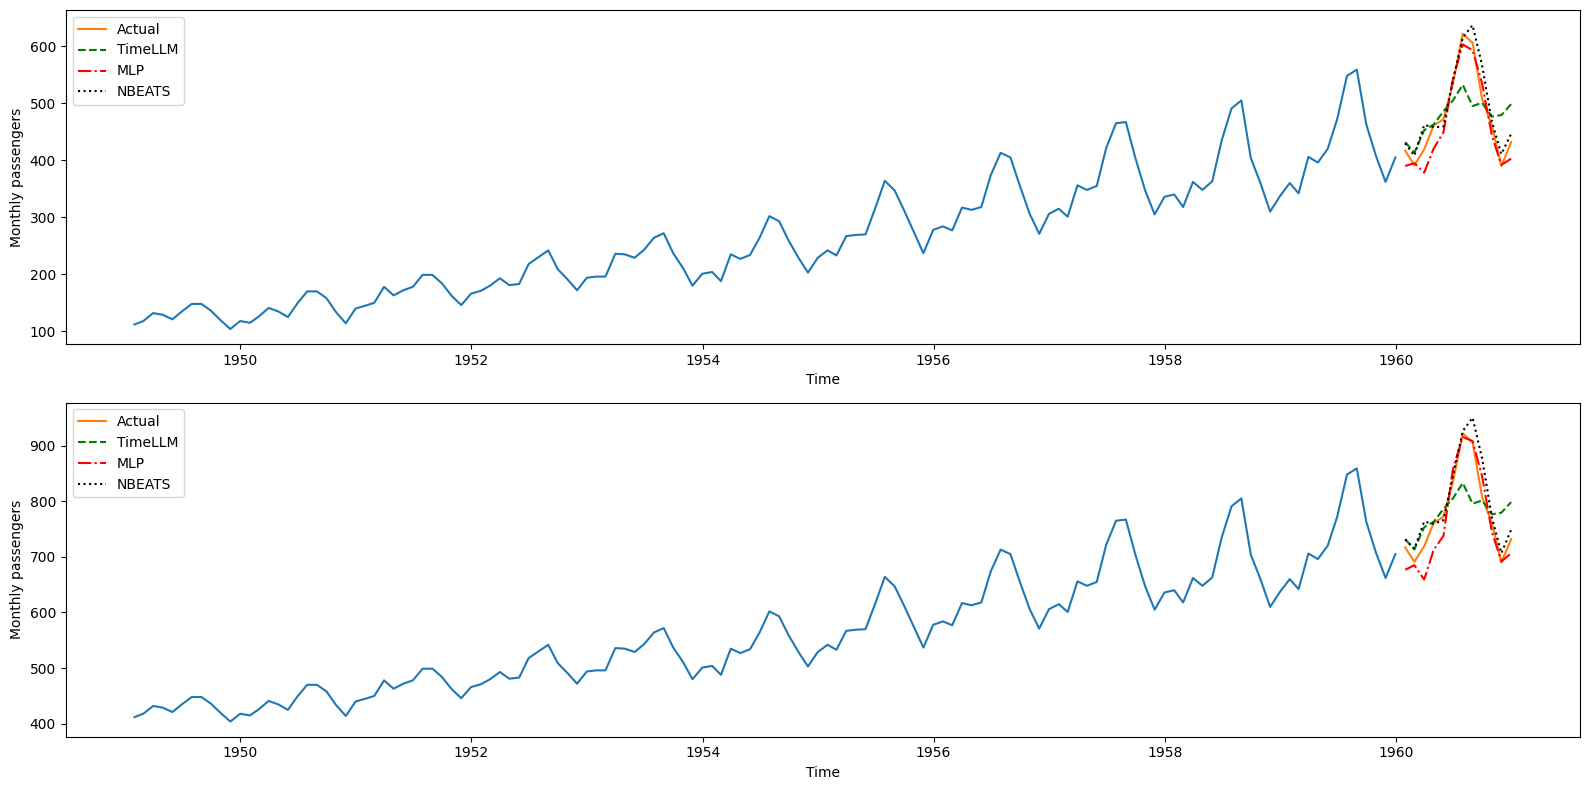

In [11]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
ax1.plot(airline1_df['ds'], airline1_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax1.plot(airline1_df['ds'], airline1_df['MLP'], label='MLP', ls='-.', color='red')
ax1.plot(airline1_df['ds'], airline1_df['NBEATS'], label='NBEATS', ls=':', color='black')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
ax2.plot(airline2_df['ds'], airline2_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax2.plot(airline2_df['ds'], airline2_df['MLP'], label='MLP', ls='-.', color='red')
ax2.plot(airline2_df['ds'], airline2_df['NBEATS'], label='NBEATS', ls=':', color='black')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()

In [13]:
from neuralforecast.losses.numpy import mae

mae_timellm = mae(Y_test_df['y'], Y_test_df['TimeLLM'])
mae_nbeats = mae(Y_test_df['y'], Y_test_df['NBEATS'])
mae_mlp = mae(Y_test_df['y'], Y_test_df['MLP'])

data = {'Time-LLM': [mae_timellm], 
       'N-BEATS': [mae_nbeats],
       'MLP': [mae_mlp]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,Time-LLM,N-BEATS,MLP
mae,41.289583,20.523328,22.918771
